[View in Colaboratory](https://colab.research.google.com/github/hernandosalas/hernandosalas.github.io/blob/master/CharityML.ipynb)

In [9]:
#Install Kaggle API
!pip install kaggle

In [10]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [11]:
#return a list of the competitions on Kaggle.
!kaggle competitions list

ref                                             deadline             category            reward  teamCount  userHasEntered  
----------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
imagenet-object-detection-challenge             2029-12-31 07:00:00  Research         Knowledge          0           False  
imagenet-object-detection-from-video-challenge  2029-12-31 07:00:00  Research         Knowledge          0           False  
imagenet-object-localization-challenge          2029-12-31 07:00:00  Research         Knowledge          8           False  
titanic                                         2020-04-07 00:00:00  Getting Started  Knowledge      11214            True  
house-prices-advanced-regression-techniques     2020-03-01 23:59:00  Getting Started  Knowledge       5357            True  
digit-recognizer                                2020-01-07 00:00:00  Getting Started  Knowledge       2417           False  


In [12]:
#list of the files for the titanic competition.
!kaggle competitions files -c titanic

name                   size  creationDate         
---------------------  ----  -------------------  
train.csv              60KB  2013-06-28 13:40:25  
test.csv               28KB  2013-06-28 13:40:24  
gender_submission.csv   3KB  2017-02-01 01:49:18  


In [13]:
#This will download all of the files from the Titanic competition to the directory “/content/kaggle/”.
!kaggle competitions download  -c titanic -p /content/kaggle

train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
#LIBRARIES
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import Imputer
from xgboost import XGBRegressor
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
import seaborn as sns
from io import StringIO
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

In [15]:
# LOADING CSV TO GOOGLE COLAB
from google.colab import files
uploaded = files.upload()

In [16]:
# LOADING CSV TO GOOGLE COLAB
from google.colab import files
uploaded = files.upload()

In [0]:
# Use if test and train are separate LOAD CSV to DATA dataframe
#trainData = pd.read_csv("train.csv",header = 0)
#testData = pd.read_csv("test.csv",header = 0)
trainData = pd.read_csv('/content/kaggle/train.csv', header=0, sep=',', quotechar='"')
testData = pd.read_csv('/content/kaggle/test.csv', header=0, sep=',', quotechar='"')
originalData = pd.concat([trainData,testData])
data = originalData
# LOAD CSV to DATA dataframe
#originalData = pd.read_csv("titanic.csv") 

In [35]:
# Before dropping features
#trainData.head()
testData.head()
#data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [0]:
# Feature Selection (Dropping features not needed)
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Parch']
data = data.drop(drop_elements, axis = 1)

In [20]:
# to see features and target variable
data.head()

,Age,Embarked,Fare,Pclass,Sex,SibSp,Survived
0,22.0,S,7.2500,3,male,1,0.0
1,38.0,C,71.2833,1,female,1,1.0
2,26.0,S,7.9250,3,female,0,1.0
3,35.0,S,53.1000,1,female,1,1.0
4,35.0,S,8.0500,3,male,0,0.0


In [21]:
# Well know question is is there any NaN value and length of this data so lets look at info
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 7 columns):
Age         1046 non-null float64
Embarked    1307 non-null object
Fare        1308 non-null float64
Pclass      1309 non-null int64
Sex         1309 non-null object
SibSp       1309 non-null int64
Survived    891 non-null float64
dtypes: float64(3), int64(2), object(2)
memory usage: 81.8+ KB


In [22]:
# How many NaNs
print("---How many NaNs---","\n")
print(data.isnull().sum(),"\n")

---How many NaNs--- 

Age         263
Embarked      2
Fare          1
Pclass        0
Sex           0
SibSp         0
Survived    418
dtype: int64 



In [23]:
# drop NaN
print("---Before dropping NaNs---","\n")
print (data.shape)
data = data.dropna()
print("---After dropping NaNs---","\n")
print (data.shape)

---Before dropping NaNs--- 

(1309, 7)
---After dropping NaNs--- 

(712, 7)


Number that Died:  424
Number that Survived :  288


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


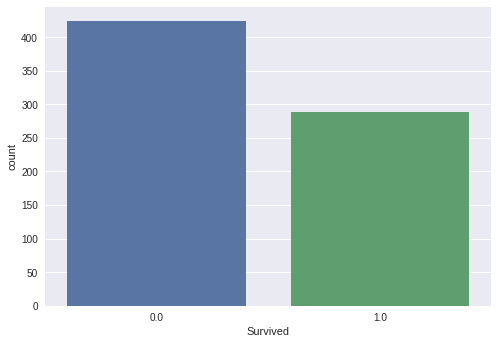

In [24]:
ax = sns.countplot(data['Survived'],label="Count")       
B, M = data['Survived'].value_counts()
print('Number that Died: ',B)
print('Number that Survived : ',M)

In [0]:
#Encoding categorical into numerical including column type
data['Sex'].replace(['female','male'],[str(0),str(1)],inplace=True)
data['Embarked'].replace(['S','C','Q'],[str(0),str(1),str(2)],inplace=True)
data["Embarked"] = data["Embarked"].astype(float)
data["Sex"] = data["Sex"].astype(float)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:637: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data[hue_mask])
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:885: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data[hue_mask])
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:905: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


Text(0.5,1,'Survival across AgeGroup and Fare')

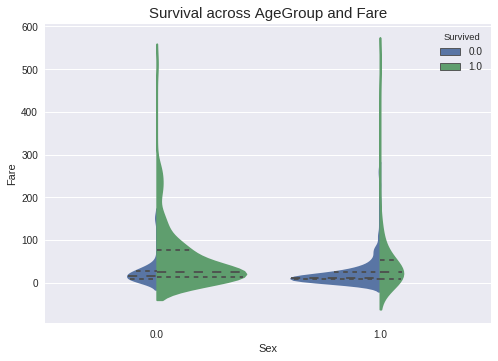

In [26]:
# Violin Plot
v9 = sns.violinplot(data=data, x='Sex', y='Fare', hue='Survived', scale='count', split=True, inner="quart")
v9.set_title('Survival across AgeGroup and Fare', fontsize = 15)

In [27]:
# Dataset statistics
data.describe()
data.head()

,Age,Embarked,Fare,Pclass,Sex,SibSp,Survived
0,22.0,0.0,7.2500,3,1.0,1,0.0
1,38.0,1.0,71.2833,1,0.0,1,1.0
2,26.0,0.0,7.9250,3,0.0,0,1.0
3,35.0,0.0,53.1000,1,0.0,1,1.0
4,35.0,0.0,8.0500,3,1.0,0,0.0


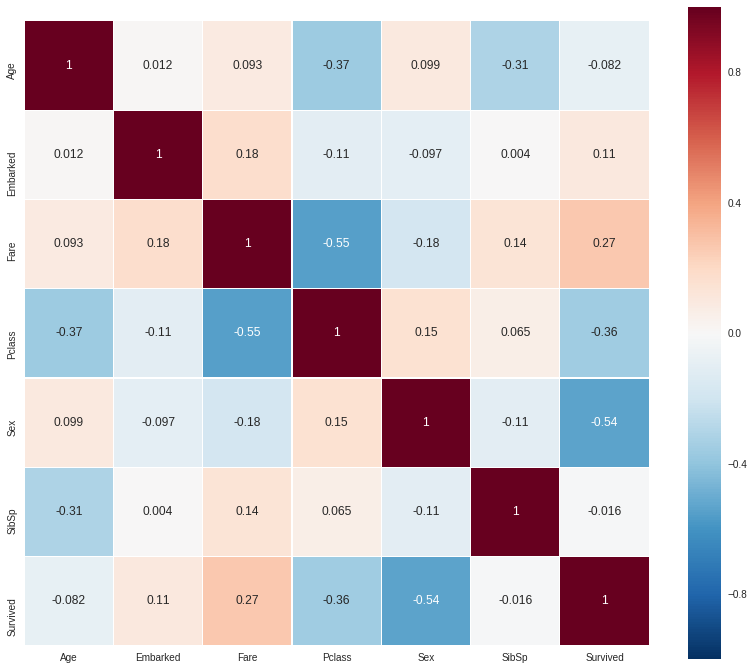

In [28]:
#Lets see the Correlation between the features
plt.figure(figsize=(14,12))
sns.heatmap(data.astype(float).corr(),linewidths=0.1, 
            square=True,  linecolor='white', annot=True)
plt.show()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 0 to 890
Data columns (total 7 columns):
Age         712 non-null float64
Embarked    712 non-null float64
Fare        712 non-null float64
Pclass      712 non-null int64
Sex         712 non-null float64
SibSp       712 non-null int64
Survived    712 non-null float64
dtypes: float64(5), int64(2)
memory usage: 64.5 KB


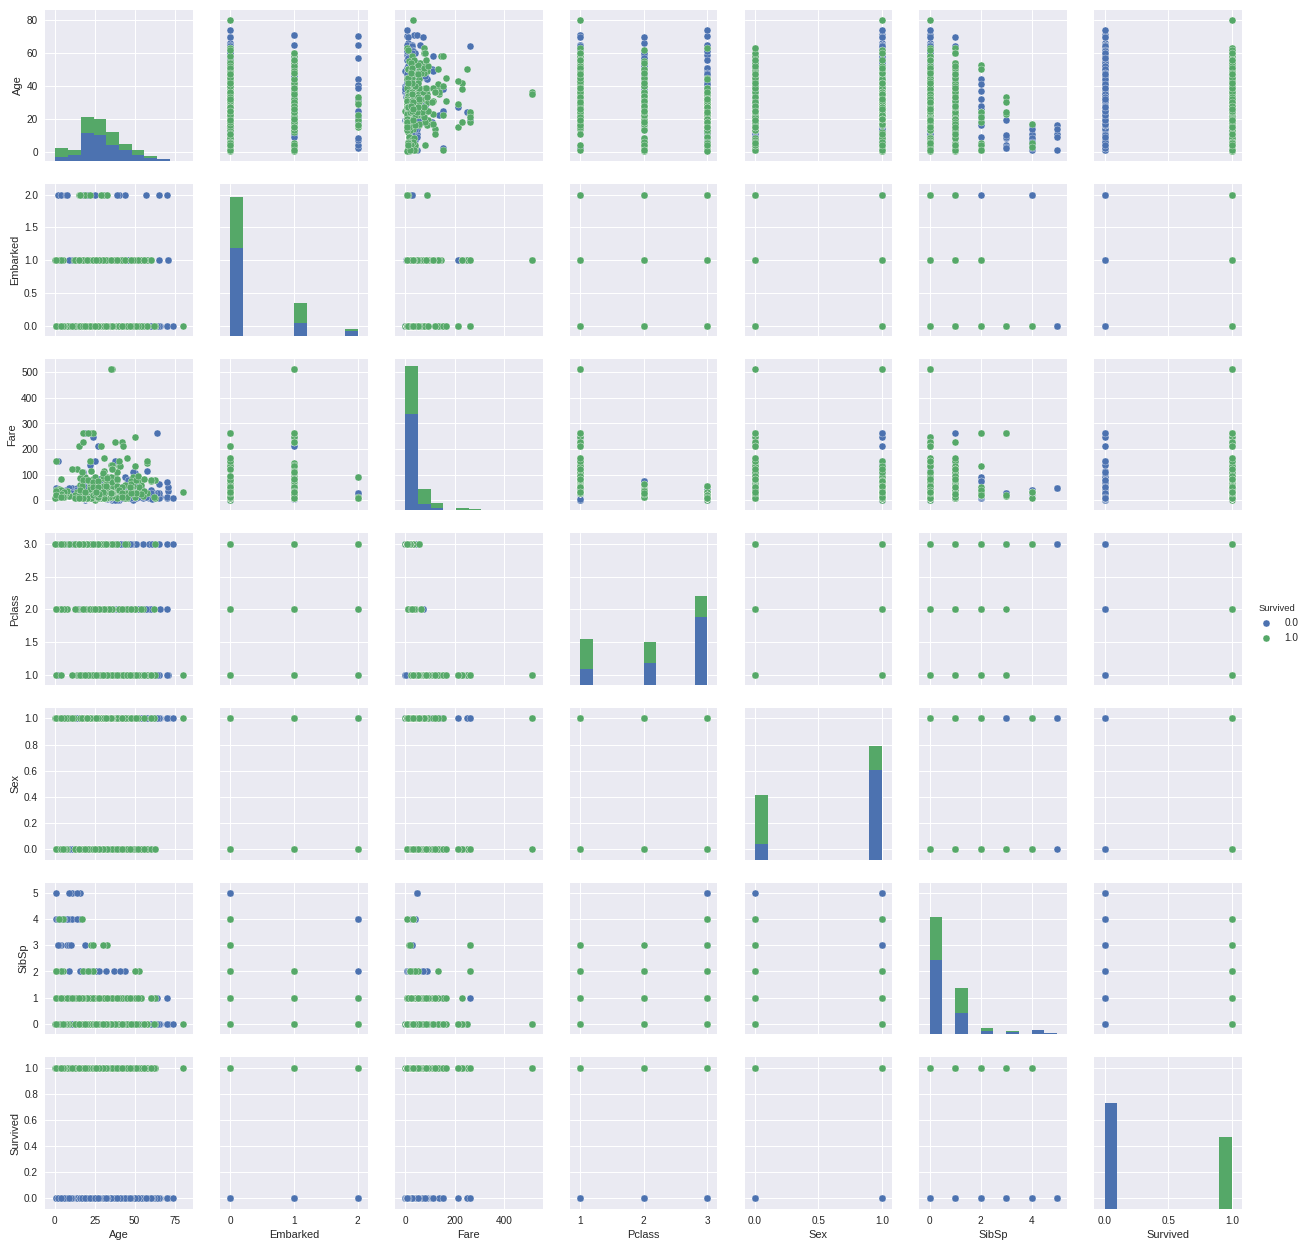

In [29]:
plt.figure()
data["Embarked"] = data["Embarked"].astype(float)
data["Sex"] = data["Sex"].astype(float)
data.info()
sns.pairplot(data=data,hue="Survived", dropna=True)
#sns.pairplot(data=data[["Fare","Survived","Age","Pclass","Embarked"]],hue="Survived", dropna=True)



In [0]:
# split data train 80 % and test 20 %
x_train, x_test, y_train, y_test = train_test_split(data.drop(['Survived'], axis = 1), data['Survived'], test_size=0.2, random_state=42)

Random Forest score: 0.804


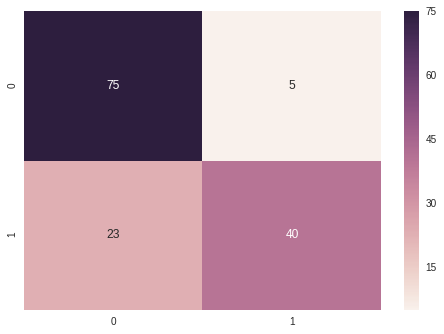

In [31]:
#RANDOM FOREST
# Define model
parameters = {'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 100, 
                  'min_samples_split': 3, 'max_features': 'auto', 'max_depth': 6}
forest = RandomForestClassifier(**parameters)
# Fit model
forest.fit(x_train, y_train)
print("Random Forest score: {0:.3}".format(forest.score(x_test, y_test)))
cm = confusion_matrix(y_test,forest.predict(x_test))
# Heat map confusion matrix
sns.heatmap(cm,annot=True,fmt="d")

In [40]:
#Make predictions using the features from the test data set
testDatatemp = testData
drop_elements_testDatatemp = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Parch']
testDatatemp = testDatatemp.drop(drop_elements, axis = 1)
#Encoding categorical into numerical including column type
testDatatemp['Sex'].replace(['female','male'],[str(0),str(1)],inplace=True)
testDatatemp['Embarked'].replace(['S','C','Q'],[str(0),str(1),str(2)],inplace=True)
testDatatemp["Embarked"] = testDatatemp["Embarked"].astype(float)
testDatatemp["Sex"] = testDatatemp["Sex"].astype(float)

print(testDatatemp.head())
predictions = forest.predict(testDatatemp)
print(predictions)

   Pclass  Sex   Age  SibSp     Fare  Embarked
0       3  1.0  34.5      0   7.8292       2.0
1       3  0.0  47.0      1   7.0000       0.0
2       2  1.0  62.0      0   9.6875       2.0
3       3  1.0  27.0      0   8.6625       0.0
4       3  0.0  22.0      1  12.2875       0.0


ValueError: ignored

In [0]:
#Create a  DataFrame with the passengers ids and our prediction regarding whether they survived or not
submission = pd.DataFrame({'PassengerId':test['PassengerId'],'Survived':predictions})

#Visualize the first 5 rows
submission.head()

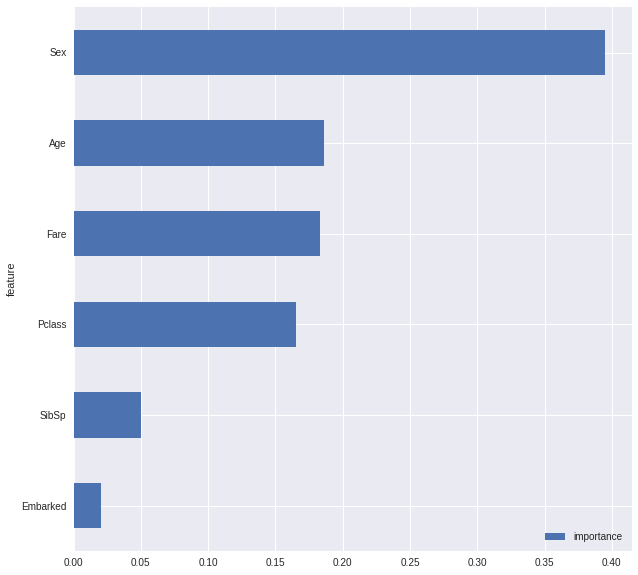

In [32]:
#the importance of each feature
features = pd.DataFrame()
features['feature'] = x_train.columns
features['importance'] = forest.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)
features.plot(kind='barh', figsize=(10, 10))

In [95]:
# turn run_gs to True if you want to run the gridsearch again.
run_gs = True
train = x_train
targets = y_train

if run_gs:
    parameter_grid = {
                 'max_depth' : [4, 6, 8],
                 'n_estimators': [200, 100, 50],
                 'max_features': ['sqrt', 'auto', 'log2'],
                 'min_samples_split': [2, 3, 10],
                 'min_samples_leaf': [1, 3, 10],
                 'bootstrap': [True, False],
                 }
    forest = RandomForestClassifier()
    cross_validation = StratifiedKFold(n_splits=5)

    grid_search = GridSearchCV(forest,
                               scoring='accuracy',
                               param_grid=parameter_grid,
                               cv=cross_validation,
                               verbose=1
                              )

    grid_search.fit(train, targets)
    model = grid_search
    parameters = grid_search.best_params_

    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
    
else: 
    parameters = {'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 50, 
                  'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 6}
    
    model = RandomForestClassifier(**parameters)
    model.fit(train, targets)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Best score: 0.8295254833040422
Best parameters: {'bootstrap': True, 'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}


[Parallel(n_jobs=1)]: Done 2430 out of 2430 | elapsed:  6.4min finished
